In [1]:
using AutomotiveDrivingModels
using AutoViz

In [2]:
roadway = gen_stadium_roadway(1)
scene = Scene(2)
scene.n = 2
def = VehicleDef(AgentClass.CAR, 2.0, 1.0)

function place_at!(i, s)
    roadproj = proj(VecSE2(0.0,0.0,0.0), roadway)
    roadind = RoadIndex(roadproj.curveproj.ind, roadproj.tag)
    roadind = move_along(roadind, roadway, s)
    frenet = Frenet(roadind, roadway[roadind].s, 0.0, 0.0)
    state = VehicleState(frenet, roadway, 0.0)
    scene[i] = Vehicle(state, def, i)
end

place_at! (generic function with 1 method)

In [26]:
place_at!(1, 0.0)
place_at!(2, 100.0)

Vehicle(2, VehicleState(VecSE2({100.006, 0.000}, 0.000), Frenet(RoadIndex({1, 0.003730}, {1, 1}), 0.006, 0.000, 0.000), 0.000), VehicleDef(CAR, 2.000, 1.000))

In [27]:
foreinfo = get_neighbor_fore_along_lane(scene, 2, roadway, max_distance_fore=Inf)


coucou
LaneTag(1, 1)
0.006103515625
AutomotiveDrivingModels.VehicleTargetPointCenter()
AutomotiveDrivingModels.VehicleTargetPointCenter()
Inf
2
vehicle is in target lane
searched LaneTag(1, 1)
dist_searched = 39.263804654247416
now searching LaneTag(2, 1)
searched LaneTag(2, 1)
dist_searched = 88.53371282411983
now searching LaneTag(3, 1)
searched LaneTag(3, 1)
dist_searched = 227.80362099399224
now searching LaneTag(4, 1)
vehicle is in exit
found vehicle! 1


AutomotiveDrivingModels.NeighborLongitudinalResult(1, 277.0796326794897)

In [28]:
is_in_exits(roadway[LaneTag(2,1)], LaneTag(1,1))

false

In [24]:
roadway[LaneTag(1,1)].curve[end].s

39.269908169872416

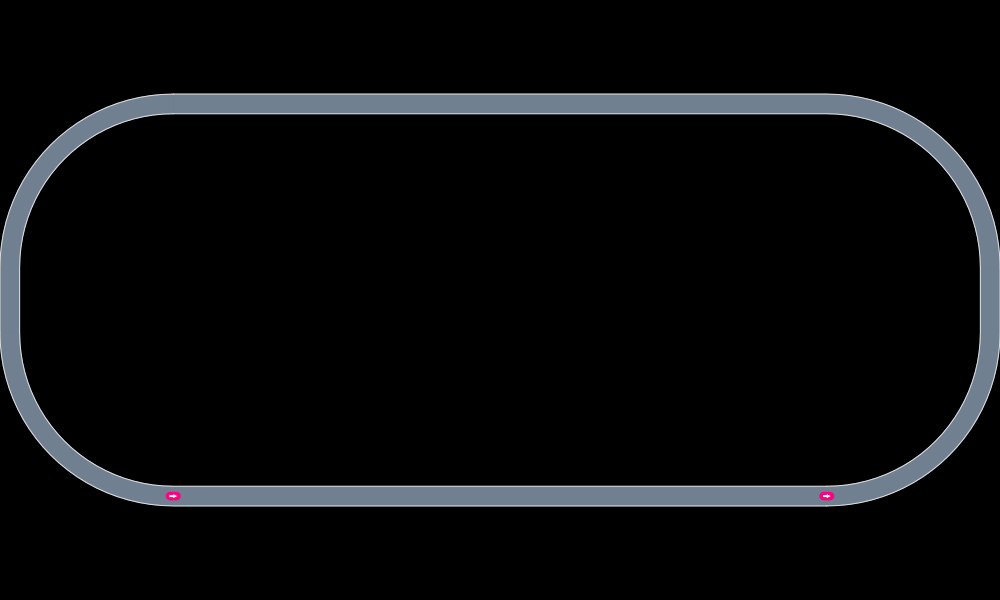

In [10]:
render(scene, roadway, cam=FitToContentCamera(0.))

In [25]:
function AutomotiveDrivingModels.get_neighbor_fore_along_lane(
    scene::EntityFrame{S,D,I},
    roadway::Roadway,
    tag_start::LaneTag,
    s_base::Float64,
    targetpoint_primary::VehicleTargetPoint, # the reference point whose distance we want to minimize
    targetpoint_valid::VehicleTargetPoint; # the reference point, which if distance to is positive, we include the vehicle
    max_distance_fore::Float64 = 250.0, # max distance to search forward [m]
    index_to_ignore::Int=-1,
    ) where {S<:VehicleState,D<:Union{VehicleDef, BicycleModel},I}
        println("\ncoucou")
    println(tag_start)
    println(s_base)
    println(targetpoint_primary)
    println(targetpoint_valid)
    println(max_distance_fore)
    println(index_to_ignore)
    best_ind = 0
    best_dist = max_distance_fore
    tag_target = tag_start

    dist_searched = 0.0
    while dist_searched < max_distance_fore

        lane = roadway[tag_target]

        for (i,veh) in enumerate(scene)
            if i != index_to_ignore

                s_adjust = NaN
                if veh.state.posF.roadind.tag == tag_target
                    s_adjust = 0.0
                    println("vehicle is in target lane")
                elseif is_between_segments_hi(veh.state.posF.roadind.ind, lane.curve) &&
                       is_in_entrances(roadway[tag_target], veh.state.posF.roadind.tag)
                    println("vehicle is in entrance")
                    distance_between_lanes = norm(VecE2(roadway[tag_target].curve[1].pos - roadway[veh.state.posF.roadind.tag].curve[end].pos))
                    s_adjust = -(roadway[veh.state.posF.roadind.tag].curve[end].s + distance_between_lanes)

                elseif is_between_segments_lo(veh.state.posF.roadind.ind) &&
                       is_in_exits(roadway[tag_target], veh.state.posF.roadind.tag)
                    println("vehicle is in exit")
                    distance_between_lanes = norm(VecE2(roadway[tag_target].curve[end].pos - roadway[veh.state.posF.roadind.tag].curve[1].pos))
                    s_adjust = roadway[tag_target].curve[end].s + distance_between_lanes
                end

                if !isnan(s_adjust)
                    s_valid = veh.state.posF.s + get_targetpoint_delta(targetpoint_valid, convert(Vehicle, veh)) + s_adjust
                    dist_valid = s_valid - s_base + dist_searched
                    if dist_valid ≥ 0.0
                        s_primary = veh.state.posF.s + get_targetpoint_delta(targetpoint_primary, convert(Vehicle, veh)) + s_adjust
                        dist = s_primary - s_base + dist_searched
                        if dist < best_dist
                            best_dist = dist
                            best_ind = i
                        end
                    end
                end
            end
        end

        if best_ind != 0
            println("found vehicle! $best_ind")
            break
        end

        if !has_next(lane) ||
           (tag_target == tag_start && dist_searched != 0.0) # exit after visiting this lane a 2nd time
            break
        end

        dist_searched += (lane.curve[end].s - s_base)
        s_base = -norm(VecE2(lane.curve[end].pos - next_lane_point(lane, roadway).pos)) # negative distance between lanes
        println("searched $tag_target")
        tag_target = next_lane(lane, roadway).tag
        println("dist_searched = $dist_searched")
        println("now searching $tag_target")
    end

    NeighborLongitudinalResult(best_ind, best_dist)
end